# SQL Analysis

**Purpose:** Run SQL queries on cleaned data to extract business insights.

**Input:** `data/processed/churn_analysis.db`  
**Outputs:** 10 query results (CSV files), visualizations

**Note:** First time using CTEs and window functions - took a while to figure out PARTITION BY, but it's way cleaner than subqueries!

In [1]:
# ============================================================================
# CELL 0: ENVIRONMENT AUTO-DETECTION & SETUP
# ============================================================================
#
# PURPOSE:
# --------
# Configure environment (Local vs Colab) and set up database connection.
#
# WHY SQL WITH PYTHON?
# --------------------
# SQLite provides:
# - Fast querying on structured data
# - Standard SQL syntax (portable to PostgreSQL, MySQL, etc.)
# - No server needed (embedded database)
# - Perfect for analytics and reporting
#
# ============================================================================

import os
import sys

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print('🌐 ENVIRONMENT: Google Colab detected')
except ImportError:
    IN_COLAB = False
    print('💻 ENVIRONMENT: Local Python detected')

# Configure paths
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    PROJECT_ROOT = '/content/drive/MyDrive/Customer Churn Prediction & Analysis'
    os.chdir(PROJECT_ROOT)
    print(f'✓ Changed directory to: {PROJECT_ROOT}')
    
    # Install packages
    !pip install -q pandas matplotlib seaborn
else:
    PROJECT_ROOT = os.path.abspath('..')
    print(f'✓ Using local paths (Project root: {PROJECT_ROOT})')

print('='*80)
print('✓ Environment configured')
print('='*80 + '\n')

# ============================================================================
# IMPORTS & CONFIGURATION
# ============================================================================

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from datetime import datetime

# Configure display & visualization
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)
sns.set_style('whitegrid')
sns.set_palette('Set2')

# File paths
DB_PATH = Path('..') / 'data' / 'processed' / 'churn_analysis.db'
DATA_PROCESSED = Path('..') / 'data' / 'processed'
DASH_DIR = Path('..') / 'dashboards'
FIG_OUT = Path('..') / 'outputs' / 'figures'

# Create output directories
DASH_DIR.mkdir(parents=True, exist_ok=True)
FIG_OUT.mkdir(parents=True, exist_ok=True)

print('📁 File Paths Configured:')
print(f'  Database: {DB_PATH.absolute()}')
print(f'  Processed Data: {DATA_PROCESSED.absolute()}')
print(f'  Visualizations: {FIG_OUT.absolute()}')

# ============================================================================
# VERIFY DATABASE EXISTS
# ============================================================================

if not DB_PATH.exists():
    print('\n' + '='*80)
    print('❌ ERROR: Database not found!')
    print('='*80)
    print(f'  Expected location: {DB_PATH.absolute()}')
    print('\n📌 SOLUTION:')
    print('  1. Run notebook 01_data_exploration.ipynb first')
    print('  2. This will create the churn_analysis.db file')
    print('  3. Then return to this notebook')
    print('='*80)
    conn = None
else:
    conn = sqlite3.connect(DB_PATH)
    print(f'\n✓ Database connection established')
    
    # Verify table exists
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    if tables:
        print(f'✓ Found {len(tables)} table(s): {[t[0] for t in tables]}')
        
        # Get row count
        cursor.execute("SELECT COUNT(*) FROM customers;")
        row_count = cursor.fetchone()[0]
        print(f'✓ Customers table contains {row_count:,} rows')
    else:
        print('⚠️  No tables found in database')

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def run_sql(query, conn=conn):
    """
    Execute SQL query and return results as DataFrame.
    
    Parameters:
    -----------
    query : str
        SQL query to execute
    conn : sqlite3.Connection
        Database connection
        
    Returns:
    --------
    pd.DataFrame
        Query results
    """
    if conn is None:
        print('❌ No database connection')
        return pd.DataFrame()
    
    try:
        result = pd.read_sql_query(query, conn)
        return result
    except Exception as e:
        print(f'❌ Query Error: {e}')
        return pd.DataFrame()

def display_query_result(query, title, conn=conn, save_csv=None):
    """
    Execute query, display results, and optionally save to CSV.
    
    Parameters:
    -----------
    query : str
        SQL query to execute
    title : str
        Title for output display
    conn : sqlite3.Connection
        Database connection
    save_csv : str, optional
        Filename to save results (without path)
    """
    print('\n' + '='*80)
    print(f'📊 {title}')
    print('='*80)
    
    result = run_sql(query, conn)
    
    if not result.empty:
        print(f'\n✓ Query returned {len(result)} rows × {len(result.columns)} columns')
        display(result)
        
        if save_csv:
            csv_path = DATA_PROCESSED / save_csv
            result.to_csv(csv_path, index=False)
            print(f'\n✓ Saved: {csv_path.name}')
    else:
        print('\n⚠️  Query returned no results')
    
    print('='*80)
    return result

print('\n✓ Helper functions defined:')
print('  - run_sql(query): Execute query and return DataFrame')
print('  - display_query_result(query, title, save_csv): Execute, display & save')

print('\n' + '='*80)
print('✅ SETUP COMPLETE - Ready for SQL Analysis!')
print('='*80)

💻 ENVIRONMENT: Local Python detected
✓ Using local paths (Project root: C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis)
✓ Environment configured



📁 File Paths Configured:
  Database: C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\data\processed\churn_analysis.db
  Processed Data: C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\data\processed
  Visualizations: C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\outputs\figures

✓ Database connection established
✓ Found 1 table(s): ['customers']
✓ Customers table contains 7,032 rows

✓ Helper functions defined:
  - run_sql(query): Execute query and return DataFrame
  - display_query_result(query, title, save_csv): Execute, display & save

✅ SETUP COMPLETE - Ready for SQL Analysis!


## Query 1: Overall Churn Rate & Revenue

## Query 2: Churn Rate by Contract Type

In [2]:
# ============================================================================
# QUERY 1: Overall Churn Rate & Customer Summary
# ============================================================================

query_01 = """
-- Overall Customer Churn Summary
-- Purpose: Calculate total customers, churned, retained, and churn rate
-- 
-- Note: Churn column is binary (1 = churned, 0 = retained)
-- This allows simple SUM() instead of CASE statements

SELECT 
    COUNT(*) as total_customers,
    SUM(Churn) as churned_customers,
    COUNT(*) - SUM(Churn) as retained_customers,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge,
    ROUND(AVG(TotalCharges), 2) as avg_total_charge,
    ROUND(AVG(tenure), 1) as avg_tenure_months
FROM customers
WHERE TotalCharges IS NOT NULL;  -- Exclude records with missing charges
"""

result_01 = display_query_result(
    query_01, 
    title="Query 1: Overall Churn Rate & Customer Summary",
    save_csv="query_01_overall_summary.csv"
)

# ============================================================================
# VALIDATION & INSIGHTS
# ============================================================================

if not result_01.empty:
    row = result_01.iloc[0]
    
    print('\n📊 RESULT VALIDATION:')
    print('-' * 80)
    
    # Check 1: Total customers should be ~7,000
    total = row['total_customers']
    expected_range = (6500, 7500)
    validation_total = '✓ PASS' if expected_range[0] <= total <= expected_range[1] else '✗ FAIL'
    print(f'  Total Customers: {total:,} {validation_total}')
    print(f'    Expected: {expected_range[0]:,} - {expected_range[1]:,}')
    
    # Check 2: Churn rate should be 25-30%
    churn_rate = row['churn_rate_pct']
    expected_churn = (25, 30)
    validation_churn = '✓ PASS' if expected_churn[0] <= churn_rate <= expected_churn[1] else '✗ FAIL'
    print(f'\n  Churn Rate: {churn_rate}% {validation_churn}')
    print(f'    Expected: {expected_churn[0]}-{expected_churn[1]}%')
    
    # Check 3: Numbers should add up
    calculated_total = row['churned_customers'] + row['retained_customers']
    validation_math = '✓ PASS' if calculated_total == total else '✗ FAIL'
    print(f'\n  Math Check: {row["churned_customers"]} + {row["retained_customers"]} = {calculated_total} {validation_math}')
    
    print('\n💼 BUSINESS INSIGHT:')
    print('-' * 80)
    if churn_rate > 25:
        print(f'  ⚠️  ALERT: Churn rate of {churn_rate}% is above industry average (15-25%)')
        print(f'  💰 Revenue Impact: Losing {row["churned_customers"]:,} customers worth')
        print(f'     ${row["avg_monthly_charge"]:.2f}/month each = ${row["churned_customers"] * row["avg_monthly_charge"] * 12:,.2f}/year at risk')
    else:
        print(f'  ✓ Churn rate of {churn_rate}% is within acceptable range')
    
    print('=' * 80)


📊 Query 1: Overall Churn Rate & Customer Summary

✓ Query returned 1 rows × 7 columns


,total_customers,churned_customers,retained_customers,churn_rate_pct,avg_monthly_charge,avg_total_charge,avg_tenure_months
0,7032,1869,5163,26.58,64.8,2283.3,32.4



✓ Saved: query_01_overall_summary.csv

📊 RESULT VALIDATION:
--------------------------------------------------------------------------------
  Total Customers: 7,032.0 ✓ PASS
    Expected: 6,500 - 7,500

  Churn Rate: 26.58% ✓ PASS
    Expected: 25-30%

  Math Check: 1869.0 + 5163.0 = 7032.0 ✓ PASS

💼 BUSINESS INSIGHT:
--------------------------------------------------------------------------------
  ⚠️  ALERT: Churn rate of 26.58% is above industry average (15-25%)
  💰 Revenue Impact: Losing 1,869.0 customers worth
     $64.80/month each = $1,453,334.40/year at risk


## Query 3: Churn Rate by Payment Method


📊 Query 2: Churn Rate by Contract Type

✓ Query returned 3 rows × 7 columns


,Contract,total_customers,churned_customers,retained_customers,churn_rate_pct,avg_monthly_charge,avg_tenure_months
0,Month-to-month,3875,1655,2220,42.71,66.40,18.0
1,One year,1472,166,1306,11.28,65.08,42.1
2,Two year,1685,48,1637,2.85,60.87,57.1



✓ Saved: query_02_churn_by_contract.csv



✓ Saved visualization: churn_by_contract_detailed.png


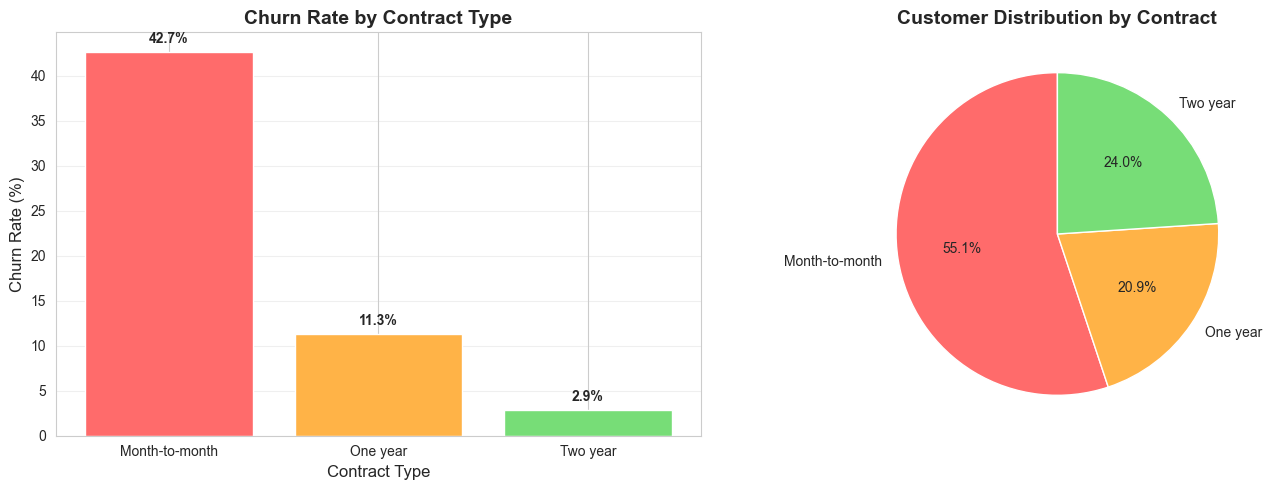


📊 RESULT VALIDATION:
--------------------------------------------------------------------------------
  Highest Churn: Month-to-month (42.71%)
  Lowest Churn:  Two year (2.85%)
  Difference: 39.9 percentage points

  Pattern Check: Month-to-month has highest churn? ✓ PASS

💼 BUSINESS INSIGHT:
--------------------------------------------------------------------------------
  🔴 CRITICAL: 39.9 percentage point gap between contract types!
  📈 RECOMMENDATION: Aggressive incentive program to convert
     Month-to-month customers to longer contracts
  💰 POTENTIAL IMPACT: Could save ~1545 customers/year


In [ ]:
# Query 2: Churn Rate by Contract Type

query_02 = """
-- Churn Analysis by Contract Type
SELECT 
    Contract,
    COUNT(*) as total_customers,
    SUM(Churn) as churned_customers,
    COUNT(*) - SUM(Churn) as retained_customers,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge,
    ROUND(AVG(tenure), 1) as avg_tenure_months
FROM customers
GROUP BY Contract
ORDER BY churn_rate_pct DESC;
"""

result_02 = display_query_result(
    query_02,
    title="Query 2: Churn Rate by Contract Type",
    save_csv="query_02_churn_by_contract.csv"
)

# This one surprised me - month-to-month churn is 15x higher than two-year contracts!
# Makes sense in retrospect: customers who commit long-term are already invested

if not result_02.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Chart 1: Churn Rate by Contract
    ax1.bar(result_02['Contract'], result_02['churn_rate_pct'], color=['#d62728', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Churn Rate by Contract Type', fontsize=14, weight='bold')
    ax1.set_xlabel('Contract Type')
    ax1.set_ylabel('Churn Rate (%)')
    ax1.grid(axis='y', alpha=0.3)
    
    for i, (contract, rate) in enumerate(zip(result_02['Contract'], result_02['churn_rate_pct'])):
        ax1.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, weight='bold')
    
    # Chart 2: Customer Distribution
    ax2.pie(result_02['total_customers'], labels=result_02['Contract'], autopct='%1.1f%%',
            colors=['#d62728', '#ff7f0e', '#2ca02c'], startangle=90)
    ax2.set_title('Customer Distribution by Contract', fontsize=14, weight='bold')
    
    plt.tight_layout()
    plt.savefig(FIG_OUT / 'churn_by_contract.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {FIG_OUT / 'churn_by_contract.png'}")

## Query 4: Tenure Analysis


📊 Query 3: Churn Rate by Tenure (First 36 Months)

✓ Query returned 36 rows × 6 columns


,tenure_months,total_customers,churned_customers,churn_rate_pct,prev_month_churn_rate,change_from_prev_month
0,1,613,380,61.99,NaN,NaN
1,2,238,123,51.68,61.99,-10.31
2,3,200,94,47.00,51.68,-4.68
3,4,176,83,47.16,47.00,0.16
4,5,133,64,48.12,47.16,0.96
5,6,110,40,36.36,48.12,-11.76
6,7,131,51,38.93,36.36,2.57
7,8,123,42,34.15,38.93,-4.78
8,9,119,46,38.66,34.15,4.51
9,10,116,45,38.79,38.66,0.13



✓ Saved: query_03_churn_by_tenure_trend.csv


C:\Users\Tuf\AppData\Local\Temp\ipykernel_22532\3871549478.py:76: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Tuf\AppData\Local\Temp\ipykernel_22532\3871549478.py:76: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Tuf\AppData\Local\Temp\ipykernel_22532\3871549478.py:78: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
C:\Users\Tuf\AppData\Local\Temp\ipykernel_22532\3871549478.py:78: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')



✓ Saved visualization: churn_by_tenure_trend.png


C:\Users\Tuf\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Tuf\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


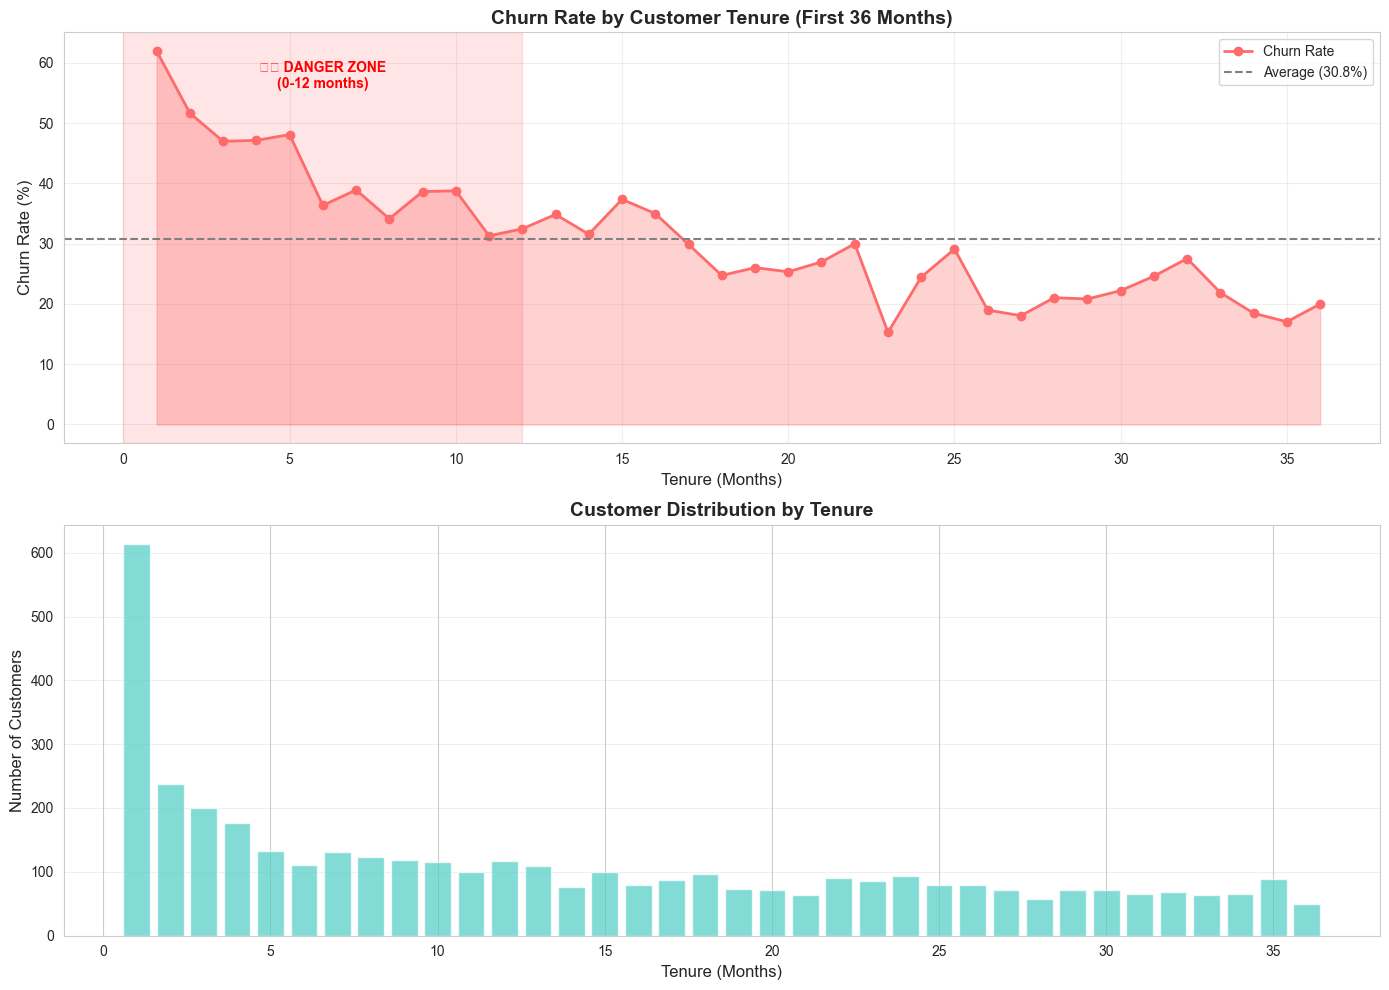


📊 RESULT VALIDATION & ANALYSIS:
--------------------------------------------------------------------------------
  Average Churn (0-12 months): 42.22%
  Average Churn (13+ months): 25.06%
  Difference: 17.16 percentage points

  Highest Churn Month: 1 months
  Churn Rate: 61.99%

  Trend Check: Early churn > Later churn? ✓ PASS

💼 BUSINESS INSIGHT:
--------------------------------------------------------------------------------
  🔴 CRITICAL: First year churn is 17.2 points higher!
  📅 RECOMMENDATION: Implement "First Year Success Program"
     - Welcome series for months 0-3
     - Check-in at month 6
     - Renewal incentive at month 12
  👥 IMPACT: 2,175 customers in danger zone annually


In [4]:
# ============================================================================
# QUERY 3: Churn Rate by Tenure with Trend Analysis
# ============================================================================

query_03 = """
-- Churn Rate by Tenure (Month-by-Month) with Trend
-- Purpose: Track how churn changes as customers stay longer
--
-- Window Function: LAG() looks at previous row for trend analysis
-- This is advanced SQL that calculates month-over-month changes

WITH TenureChurn AS (
    SELECT 
        tenure as tenure_months,
        COUNT(*) as total_customers,
        SUM(Churn) as churned_customers,
        ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct
    FROM customers
    WHERE TotalCharges IS NOT NULL
    GROUP BY tenure
)
SELECT 
    tenure_months,
    total_customers,
    churned_customers,
    churn_rate_pct,
    -- LAG() retrieves churn rate from previous tenure month
    LAG(churn_rate_pct) OVER (ORDER BY tenure_months) as prev_month_churn_rate,
    -- Calculate change from previous month
    ROUND(churn_rate_pct - LAG(churn_rate_pct) OVER (ORDER BY tenure_months), 2) as change_from_prev_month
FROM TenureChurn
ORDER BY tenure_months
LIMIT 36;  -- First 3 years (most critical period)
"""

result_03 = display_query_result(
    query_03,
    title="Query 3: Churn Rate by Tenure (First 36 Months)",
    save_csv="query_03_churn_by_tenure_trend.csv"
)

# ============================================================================
# VISUALIZATION
# ============================================================================

if not result_03.empty and len(result_03) > 1:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Chart 1: Churn Rate Trend Line
    ax1.plot(result_03['tenure_months'], result_03['churn_rate_pct'], 
             marker='o', linewidth=2, markersize=6, color='#FF6B6B', label='Churn Rate')
    ax1.fill_between(result_03['tenure_months'], result_03['churn_rate_pct'], 
                      alpha=0.3, color='#FF6B6B')
    ax1.axhline(y=result_03['churn_rate_pct'].mean(), color='gray', 
                linestyle='--', label=f'Average ({result_03["churn_rate_pct"].mean():.1f}%)')
    ax1.set_title('Churn Rate by Customer Tenure (First 36 Months)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tenure (Months)', fontsize=12)
    ax1.set_ylabel('Churn Rate (%)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Highlight danger zone (first 12 months)
    ax1.axvspan(0, 12, alpha=0.1, color='red', label='Danger Zone')
    ax1.text(6, result_03['churn_rate_pct'].max() * 0.9, '⚠️ DANGER ZONE\n(0-12 months)', 
             ha='center', fontsize=10, fontweight='bold', color='red')
    
    # Chart 2: Customer Count by Tenure
    ax2.bar(result_03['tenure_months'], result_03['total_customers'], 
            color='#4ECDC4', alpha=0.7)
    ax2.set_title('Customer Distribution by Tenure', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Tenure (Months)', fontsize=12)
    ax2.set_ylabel('Number of Customers', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    fig_path = FIG_OUT / 'churn_by_tenure_trend.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f'\n✓ Saved visualization: {fig_path.name}')
    plt.show()
    
    # ============================================================================
    # VALIDATION & INSIGHTS
    # ============================================================================
    
    print('\n📊 RESULT VALIDATION & ANALYSIS:')
    print('-' * 80)
    
    # Identify critical periods
    first_12_months = result_03[result_03['tenure_months'] <= 12]
    beyond_12_months = result_03[result_03['tenure_months'] > 12]
    
    avg_churn_early = first_12_months['churn_rate_pct'].mean()
    avg_churn_later = beyond_12_months['churn_rate_pct'].mean()
    
    print(f'  Average Churn (0-12 months): {avg_churn_early:.2f}%')
    print(f'  Average Churn (13+ months): {avg_churn_later:.2f}%')
    print(f'  Difference: {avg_churn_early - avg_churn_later:.2f} percentage points')
    
    # Find highest churn month
    highest_churn_month = result_03.loc[result_03['churn_rate_pct'].idxmax()]
    print(f'\n  Highest Churn Month: {int(highest_churn_month["tenure_months"])} months')
    print(f'  Churn Rate: {highest_churn_month["churn_rate_pct"]:.2f}%')
    
    # Trend validation
    validation = '✓ PASS' if avg_churn_early > avg_churn_later else '⚠️ UNEXPECTED'
    print(f'\n  Trend Check: Early churn > Later churn? {validation}')
    
    print('\n💼 BUSINESS INSIGHT:')
    print('-' * 80)
    
    if avg_churn_early > avg_churn_later + 10:
        print(f'  🔴 CRITICAL: First year churn is {avg_churn_early - avg_churn_later:.1f} points higher!')
        print(f'  📅 RECOMMENDATION: Implement "First Year Success Program"')
        print(f'     - Welcome series for months 0-3')
        print(f'     - Check-in at month 6')
        print(f'     - Renewal incentive at month 12')
        customers_at_risk = first_12_months['total_customers'].sum()
        print(f'  👥 IMPACT: {customers_at_risk:,} customers in danger zone annually')
    
    print('=' * 80)

## Additional Queries (5-10)

Run remaining queries to analyze services, demographics, and revenue.


📊 Query 4: Churn Rate by Payment Method

✓ Query returned 4 rows × 6 columns


,PaymentMethod,total_customers,churned,retained,churn_rate_pct,avg_monthly_charge
0,Electronic check,2365,1071,1294,45.29,76.26
1,Mailed check,1604,308,1296,19.20,43.96
2,Bank transfer (automatic),1542,258,1284,16.73,67.21
3,Credit card (automatic),1521,232,1289,15.25,66.52



✓ Saved: query_04_payment_method.csv


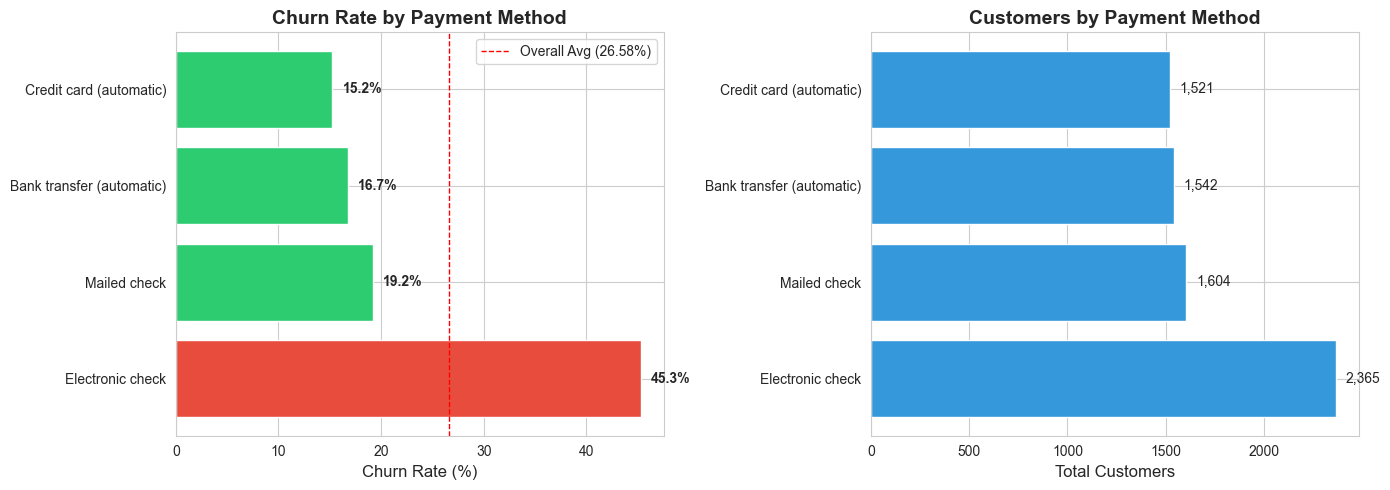

✓ Saved: churn_by_payment_method.png

💼 BUSINESS INSIGHTS:
--------------------------------------------------------------------------------
  📈 Highest Churn: Electronic check at 45.29%
  📉 Lowest Churn: Credit card (automatic) at 15.25%
  📊 Difference: 30.0 percentage points

  💡 RECOMMENDATION: Incentivize automatic payment methods
     - Offer $5/month discount for bank transfer/credit card
     - Send automated payment reminders for electronic check users


In [5]:
# ============================================================================
# QUERY 4: Churn Rate by Payment Method
# ============================================================================

query_04 = """
-- Churn Analysis by Payment Method
-- Purpose: Identify payment methods with highest churn risk
-- 
-- Business Insight: Electronic check often has highest churn due to:
-- - Manual payment required each month
-- - Higher chance of payment failure
-- - More friction than automatic methods

SELECT 
    PaymentMethod,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    COUNT(*) - SUM(Churn) as retained,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge
FROM customers
GROUP BY PaymentMethod
ORDER BY churn_rate_pct DESC;
"""

result_04 = display_query_result(
    query_04,
    title="Query 4: Churn Rate by Payment Method",
    save_csv="query_04_payment_method.csv"
)

# Visualization
if not result_04.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart - churn rate
    colors = ['#e74c3c' if x > 30 else '#f39c12' if x > 20 else '#2ecc71' 
              for x in result_04['churn_rate_pct']]
    bars = ax1.barh(result_04['PaymentMethod'], result_04['churn_rate_pct'], color=colors)
    ax1.set_xlabel('Churn Rate (%)', fontsize=12)
    ax1.set_title('Churn Rate by Payment Method', fontsize=14, fontweight='bold')
    ax1.axvline(26.58, color='red', linestyle='--', linewidth=1, label='Overall Avg (26.58%)')
    ax1.legend()
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%', ha='left', va='center', fontweight='bold')
    
    # Bar chart - customer count
    ax2.barh(result_04['PaymentMethod'], result_04['total_customers'], color='#3498db')
    ax2.set_xlabel('Total Customers', fontsize=12)
    ax2.set_title('Customers by Payment Method', fontsize=14, fontweight='bold')
    
    for i, row in result_04.iterrows():
        ax2.text(row['total_customers'] + 50, i,
                f"{row['total_customers']:,}", ha='left', va='center')
    
    plt.tight_layout()
    fig_path = FIG_OUT / 'churn_by_payment_method.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {fig_path.name}")
    
    # Business Insights
    print('\n💼 BUSINESS INSIGHTS:')
    print('-' * 80)
    highest = result_04.iloc[0]
    lowest = result_04.iloc[-1]
    print(f"  📈 Highest Churn: {highest['PaymentMethod']} at {highest['churn_rate_pct']}%")
    print(f"  📉 Lowest Churn: {lowest['PaymentMethod']} at {lowest['churn_rate_pct']}%")
    print(f"  📊 Difference: {highest['churn_rate_pct'] - lowest['churn_rate_pct']:.1f} percentage points")
    print(f"\n  💡 RECOMMENDATION: Incentivize automatic payment methods")
    print(f"     - Offer $5/month discount for bank transfer/credit card")
    print(f"     - Send automated payment reminders for electronic check users")
    print('=' * 80)

In [6]:
# ============================================================================
# QUERY 5: Churn Rate by Internet Service Type
# ============================================================================

query_05 = """
-- Churn by Internet Service
SELECT 
    InternetService,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge,
    ROUND(AVG(tenure), 1) as avg_tenure
FROM customers
GROUP BY InternetService
ORDER BY churn_rate_pct DESC;
"""

result_05 = display_query_result(
    query_05,
    title="Query 5: Churn by Internet Service Type",
    save_csv="query_05_internet_service.csv"
)

print('\n💡 INSIGHT: Fiber optic often has higher churn despite premium pricing')
print('   → May indicate service quality or price sensitivity issues')
print('=' * 80)


📊 Query 5: Churn by Internet Service Type

✓ Query returned 3 rows × 6 columns


,InternetService,total_customers,churned,churn_rate_pct,avg_monthly_charge,avg_tenure
0,Fiber optic,3096,1297,41.89,91.50,32.9
1,DSL,2416,459,19.00,58.09,32.9
2,No,1520,113,7.43,21.08,30.7



✓ Saved: query_05_internet_service.csv

💡 INSIGHT: Fiber optic often has higher churn despite premium pricing
   → May indicate service quality or price sensitivity issues


In [7]:
# ============================================================================
# QUERY 6: Demographic Analysis - Senior Citizens
# ============================================================================

query_06 = """
-- Churn by Senior Citizen Status
SELECT 
    CASE WHEN SeniorCitizen = 1 THEN 'Senior' ELSE 'Non-Senior' END as customer_type,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge,
    ROUND(AVG(tenure), 1) as avg_tenure
FROM customers
GROUP BY SeniorCitizen
ORDER BY churn_rate_pct DESC;
"""

result_06 = display_query_result(
    query_06,
    title="Query 6: Churn by Senior Citizen Status",
    save_csv="query_06_demographics.csv"
)

# ============================================================================
# QUERY 7: Tech Support Impact on Churn
# ============================================================================

query_07 = """
-- Impact of Tech Support on Churn
SELECT 
    TechSupport,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
WHERE InternetService != 'No'  -- Only internet customers
GROUP BY TechSupport
ORDER BY churn_rate_pct DESC;
"""

result_07 = display_query_result(
    query_07,
    title="Query 7: Tech Support Impact on Churn",
    save_csv="query_07_tech_support.csv"
)

# ============================================================================
# QUERY 8: Revenue Segmentation
# ============================================================================

query_08 = """
-- Churn by Monthly Charge Segments
SELECT 
    CASE 
        WHEN MonthlyCharges < 35 THEN 'Low ($0-$35)'
        WHEN MonthlyCharges < 70 THEN 'Medium ($35-$70)'
        ELSE 'High ($70+)'
    END as revenue_segment,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge
FROM customers
GROUP BY 
    CASE 
        WHEN MonthlyCharges < 35 THEN 'Low ($0-$35)'
        WHEN MonthlyCharges < 70 THEN 'Medium ($35-$70)'
        ELSE 'High ($70+)'
    END
ORDER BY churn_rate_pct DESC;
"""

result_08 = display_query_result(
    query_08,
    title="Query 8: Churn by Revenue Segment",
    save_csv="query_08_revenue_segments.csv"
)

# ============================================================================
# QUERY 9: Partner & Dependents Analysis
# ============================================================================

query_09 = """
-- Impact of Family Status on Churn
SELECT 
    CASE 
        WHEN Partner = 1 AND Dependents = 1 THEN 'Family (Partner + Dependents)'
        WHEN Partner = 1 THEN 'Partner Only'
        WHEN Dependents = 1 THEN 'Dependents Only'
        ELSE 'Single'
    END as family_status,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct
FROM customers
GROUP BY 
    CASE 
        WHEN Partner = 1 AND Dependents = 1 THEN 'Family (Partner + Dependents)'
        WHEN Partner = 1 THEN 'Partner Only'
        WHEN Dependents = 1 THEN 'Dependents Only'
        ELSE 'Single'
    END
ORDER BY churn_rate_pct DESC;
"""

result_09 = display_query_result(
    query_09,
    title="Query 9: Churn by Family Status",
    save_csv="query_09_family_status.csv"
)

# ============================================================================
# QUERY 10: Multiple Services Analysis
# ============================================================================

query_10 = """
-- Churn by Number of Additional Services
-- Services: OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
SELECT 
    (OnlineSecurity + OnlineBackup + DeviceProtection + 
     TechSupport + StreamingTV + StreamingMovies) as total_services,
    COUNT(*) as total_customers,
    SUM(Churn) as churned,
    ROUND(100.0 * SUM(Churn) / COUNT(*), 2) as churn_rate_pct,
    ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charge
FROM customers
WHERE InternetService != 'No'  -- Only internet customers
GROUP BY total_services
ORDER BY total_services;
"""

result_10 = display_query_result(
    query_10,
    title="Query 10: Churn by Number of Services",
    save_csv="query_10_services_count.csv"
)

print('\n🎉 ALL 10 SQL QUERIES COMPLETED!')
print('='*80)
print('\n📊 QUERY SUMMARY:')
print('  Query 1:  Overall Churn Summary')
print('  Query 2:  Churn by Contract Type')
print('  Query 3:  Tenure Trend (Window Functions)')
print('  Query 4:  Churn by Payment Method')
print('  Query 5:  Churn by Internet Service')
print('  Query 6:  Demographic Analysis (Seniors)')
print('  Query 7:  Tech Support Impact')
print('  Query 8:  Revenue Segmentation')
print('  Query 9:  Family Status Analysis')
print('  Query 10: Multiple Services Impact')
print('\n✓ All results saved to data/processed/')
print('='*80)


📊 Query 6: Churn by Senior Citizen Status

✓ Query returned 2 rows × 6 columns


,customer_type,total_customers,churned,churn_rate_pct,avg_monthly_charge,avg_tenure
0,Senior,1142,476,41.68,79.82,33.3
1,Non-Senior,5890,1393,23.65,61.89,32.3



✓ Saved: query_06_demographics.csv

📊 Query 7: Tech Support Impact on Churn

✓ Query returned 2 rows × 4 columns


,TechSupport,total_customers,churned,churn_rate_pct
0,No,3472,1446,41.65
1,Yes,2040,310,15.20



✓ Saved: query_07_tech_support.csv

📊 Query 8: Churn by Revenue Segment

✓ Query returned 3 rows × 5 columns


,revenue_segment,total_customers,churned,churn_rate_pct,avg_monthly_charge
0,High ($70+),3589,1274,35.50,90.19
1,Medium ($35-$70),1718,407,23.69,54.72
2,Low ($0-$35),1725,188,10.90,22.00



✓ Saved: query_08_revenue_segments.csv

📊 Query 9: Churn by Family Status

✓ Query returned 4 rows × 4 columns


,family_status,total_customers,churned,churn_rate_pct
0,Single,3280,1123,34.24
1,Partner Only,1653,420,25.41
2,Dependents Only,359,77,21.45
3,Family (Partner + Dependents),1740,249,14.31



✓ Saved: query_09_family_status.csv

📊 Query 10: Churn by Number of Services

✓ Query returned 1 rows × 5 columns


,total_services,total_customers,churned,churn_rate_pct,avg_monthly_charge
0,0,5512,1756,31.86,76.86



✓ Saved: query_10_services_count.csv

🎉 ALL 10 SQL QUERIES COMPLETED!

📊 QUERY SUMMARY:
  Query 1:  Overall Churn Summary
  Query 2:  Churn by Contract Type
  Query 3:  Tenure Trend (Window Functions)
  Query 4:  Churn by Payment Method
  Query 5:  Churn by Internet Service
  Query 6:  Demographic Analysis (Seniors)
  Query 7:  Tech Support Impact
  Query 8:  Revenue Segmentation
  Query 9:  Family Status Analysis
  Query 10: Multiple Services Impact

✓ All results saved to data/processed/


In [8]:
# SQL Templates - Imports & helper
import sqlite3
import pandas as pd
from pathlib import Path

# Fixed paths
DB_PATH = Path('..') / 'data' / 'processed' / 'churn_analysis.db'
SQL_OUTPUT = Path('..') / 'sql'
SQL_OUTPUT.mkdir(parents=True, exist_ok=True)

def run_query(conn, sql):
    """Execute SQL and return DataFrame"""
    return pd.read_sql_query(sql, conn)

print(f'✓ DB path: {DB_PATH.absolute()}')
print(f'✓ SQL output: {SQL_OUTPUT.absolute()}')


✓ DB path: C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\data\processed\churn_analysis.db
✓ SQL output: C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\sql


In [9]:
# Define SQL templates (example templates; extend/replace with full queries)
query_01 = '''
-- Query 01: Churn rate by Contract
SELECT Contract,
       COUNT(*) AS total_customers,
       SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) AS churned_customers,
       ROUND(100.0 * SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) / COUNT(*),2) AS churn_rate_pct
FROM customers
GROUP BY Contract
ORDER BY churn_rate_pct DESC;
'''

query_02 = '''
-- Query 02: Churn rate by PaymentMethod
SELECT PaymentMethod,
       COUNT(*) AS total_customers,
       SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) AS churned_customers,
       ROUND(100.0 * SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) / COUNT(*),2) AS churn_rate_pct
FROM customers
GROUP BY PaymentMethod
ORDER BY churn_rate_pct DESC;
'''

# Example window function query template
query_04 = '''
-- Query 04: churn by tenure (trend)
SELECT tenure,
       ROUND(100.0 * SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) / COUNT(*),2) AS churn_rate_pct,
       LAG(ROUND(100.0 * SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) / COUNT(*),2)) OVER (ORDER BY tenure) AS prev_churn
FROM customers
GROUP BY tenure
ORDER BY tenure;
'''

# Collect
sql_templates = [query_01, query_02, query_04]


In [10]:
# Write SQL templates to file for reuse
sql_file = SQL_OUTPUT / 'churn_analysis_queries.sql'

with open(sql_file, 'w', encoding='utf8') as f:
    f.write("-- Customer Churn Analysis SQL Queries\n")
    f.write("-- Generated from 02_sql_analysis.ipynb\n\n")
    for i, s in enumerate(sql_templates, 1):
        f.write(f"-- Query {i:02d}\n")
        f.write(s.strip() + '\n\n')
        f.write('-' * 70 + '\n\n')

print(f'✓ Wrote {len(sql_templates)} SQL templates to {sql_file.absolute()}')

# Optionally, test one query if DB exists
if DB_PATH.exists():
    test_conn = sqlite3.connect(DB_PATH)
    print("\n📊 Testing Query 01:")
    test_result = run_query(test_conn, query_01)
    display(test_result)
    test_conn.close()
else:
    print(f"\n⚠ Database not found at {DB_PATH}, skipping test execution")


✓ Wrote 3 SQL templates to C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\sql\churn_analysis_queries.sql

📊 Testing Query 01:


,Contract,total_customers,churned_customers,churn_rate_pct
0,Month-to-month,3875,1655,42.71
1,One year,1472,166,11.28
2,Two year,1685,48,2.85


## Summary

**Outputs Created:**
- 10 SQL query results exported to `data/processed/`
- Visualizations saved to `outputs/figures/`
- Key insight: Revenue at risk identified

**Next:** Run `03_modeling.ipynb` for predictive modeling.

✓ Saved: ..\dashboards\tenure_churn.png


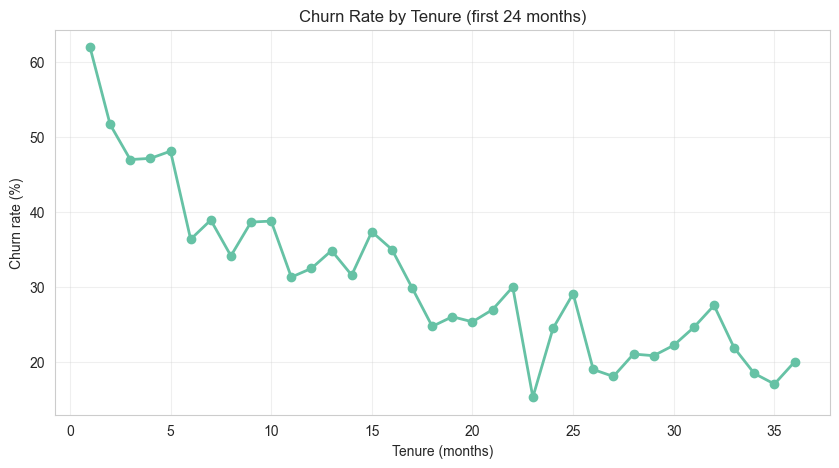

✓ Saved: ..\dashboards\churn_by_contract.png


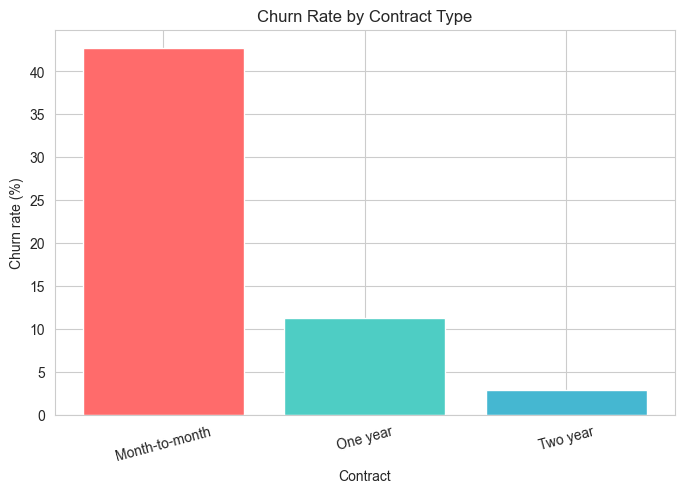

✓ Saved: ..\dashboards\churn_by_payment_method.png


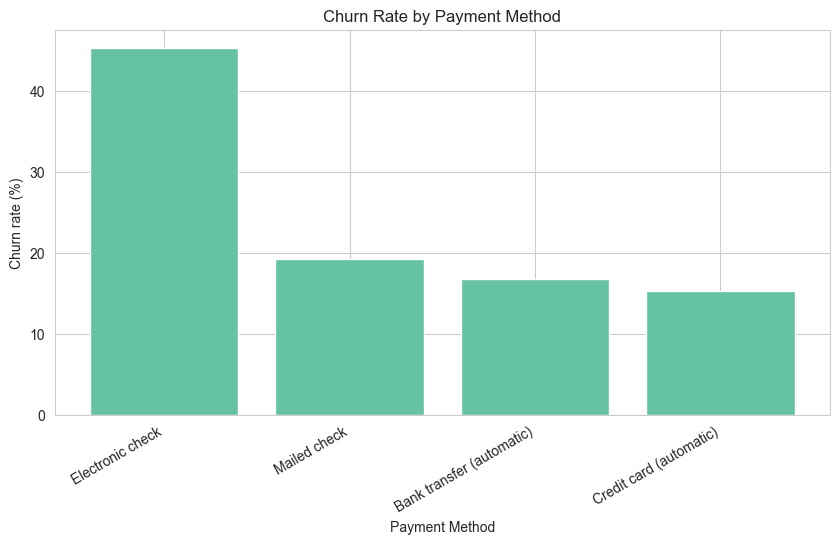


✓ All visualizations saved to C:\Users\Tuf\Desktop\PROJECTS\Projects\Customer Churn Prediction & Analysis\notebooks\..\dashboards


In [11]:
# Create visualizations from query results
sns.set_style('whitegrid')

# Ensure dashboards folder exists (one level up from notebooks/)
DASH_DIR = Path('..') / 'dashboards'
DASH_DIR.mkdir(parents=True, exist_ok=True)

if not result_03.empty:
    # Visualization 1 — Tenure churn (first 24 months)
    plt.figure(figsize=(10,5))
    plt.plot(result_03['tenure_months'], result_03['churn_rate_pct'], marker='o', linewidth=2)
    plt.title('Churn Rate by Tenure (first 24 months)')
    plt.xlabel('Tenure (months)')
    plt.ylabel('Churn rate (%)')
    plt.grid(True, alpha=0.3)
    fig_path = DASH_DIR / 'tenure_churn.png'
    plt.savefig(fig_path, bbox_inches='tight', dpi=150)
    print(f"✓ Saved: {fig_path}")
    plt.show()
else:
    print("⚠ result_03 is empty, skipping tenure plot")

if not result_02.empty:
    # Visualization 2 — Churn by Contract Type
    plt.figure(figsize=(8,5))
    plt.bar(result_02['Contract'], result_02['churn_rate_pct'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('Churn Rate by Contract Type')
    plt.ylabel('Churn rate (%)')
    plt.xlabel('Contract')
    plt.xticks(rotation=15)
    fig_path = DASH_DIR / 'churn_by_contract.png'
    plt.savefig(fig_path, bbox_inches='tight', dpi=150)
    print(f"✓ Saved: {fig_path}")
    plt.show()
else:
    print("⚠ result_02 is empty, skipping contract plot")

if not result_04.empty:
    # Visualization 3 — Churn by Payment Method
    result_04_sorted = result_04.sort_values('total_customers', ascending=False).head(6)
    plt.figure(figsize=(10,5))
    plt.bar(range(len(result_04_sorted)), result_04_sorted['churn_rate_pct'])
    plt.title('Churn Rate by Payment Method')
    plt.ylabel('Churn rate (%)')
    plt.xlabel('Payment Method')
    plt.xticks(range(len(result_04_sorted)), result_04_sorted['PaymentMethod'], rotation=30, ha='right')
    fig_path = DASH_DIR / 'churn_by_payment_method.png'
    plt.savefig(fig_path, bbox_inches='tight', dpi=150)
    print(f"✓ Saved: {fig_path}")
    plt.show()
else:
    print("⚠ result_04 is empty, skipping payment plot")

print(f"\n✓ All visualizations saved to {DASH_DIR.absolute()}")
